# Assignment 3 - Supervised Learning

## Tzu-Chun Hsieh
Netid: th264

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), which is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

## Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
3. Gain practice in implementing machine learning algorithms to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
5. Work with imagery data and the basics of computer vision approaches to machine learning
6. Develop an understanding the optimal minimum misclassification error classifier (Bayes' classifier)

In [175]:
# MAC USERS TAKE NOTE:
# For clearer plots in Jupyter notebooks on macs, run the following line of code:
%config InlineBackend.figure_format = 'retina'

In [176]:
# import packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib  import patches
import math
from scipy.stats import expon
from sklearn.linear_model import LogisticRegression
import struct
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import matplotlib as mpl
from sklearn.metrics import log_loss

## 1
### [40 points] From theory to practice: classification through logistic regression

#### Introduction
For this problem you will derive, implement through gradient descent, and test the performance of a logistic regression classifier for a binary classification problem.

In this case, we'll assume our logistic regression problem will be applied to a two dimensional feature space. Our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\intercal} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\intercal} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\intercal}$, and $x_{i,0} \triangleq 1$

As in class, we will interpret the response of the logistic regression classifier to be the likelihood of the data given the model parameters. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=y_i|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\intercal} \mathbf{x}_i)$$

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, we know the training $\mathbf{x}$ values and $y$ values, so the above probability is primarily a function of the logistic regression parameters, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the probability of our data by adjusting our model*

#### Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.


**ANSWER**  
**(a)** What is the likelihood function for all the $N$ samples in our training dataset that we will wish to maximize?   
->
$
\begin{equation*}
\prod_{i=1}^N \sigma(w^Tx_i)^{y_i}[1-\sigma(w^Tx_i)]^{1-y_i}
\end{equation*}
$  

**(b)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express part (a) as a cost function of the model parameters, $C(\mathbf{w})$, that is the negative of the logarithm of (a).    
->
$
C(w) = - \sum_{i=1}^N y_iln(\sigma(w^Tx_i)) + (1-y_i)ln(1-\sigma(w^Tx_i))
$

**(c)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$.    
->
(c)
$
\nabla_{\mathbf{w}}C(\mathbf{w}) \\
= - \sum_{i=1}^{N} y_i \frac{ \frac{\sigma(\mathbf{w}^Tx_i)}{d\mathbf{w}} }{ \sigma(\mathbf{w}^Tx_i)\ln e} + (1-y_i)\frac{\frac{(1-\sigma(\mathbf{w}^Tx_i))}{d\mathbf{w}} }{(1-\sigma(\mathbf{w}^Tx_i))\ln e} \\
= - \sum_{i = 1}^N y_i [\frac{\sigma(\mathbf{w}^Tx_i)(1-\sigma(\mathbf{w}^Tx_i))x_i}{\sigma(\mathbf{w}^Tx_i)}] + (1-y_i)[\frac{(-1)\sigma(\mathbf{w}^Tx_i)(1-\sigma(\mathbf{w}^Tx_i))x_i}{1-\sigma(\mathbf{w}^Tx_i)}] \\
= - \sum_{i=1}^N y_i(1-\sigma(\mathbf{w}^Tx_i))x_i - (1-y_i)\sigma(\mathbf{w}^Tx_i)x_i \\
= - \sum_{i=1}^N y_i(1-\sigma(\mathbf{w}^Tx_i))x_i - (1-y_i)\sigma(\mathbf{w}^Tx_i)x_i \\
= - \sum_{i=1}^N x_i[y_i - y_i\sigma(\mathbf{w}^Tx_i) -  \sigma(\mathbf{w}^Tx_i) + y_i\sigma(\mathbf{w}^Tx_i)] \\
= -\sum_{i=1}^N x_i[y_i - \sigma(\mathbf{w}^Tx_i)] \\
= \sum_{i=1}^N x_i[-y_i + \sigma(\mathbf{w}^Tx_i)] \\
$

**(d)** Write out the gradient descent update equation, assuming $\eta$ represents the learning rate.    
->
$
W_{i+1} \\
= W_i - \eta \nabla_{\mathbf{w}}C(\mathbf{w}) \\
= W_i - \eta \sum_{i=1}^N x_i[-y_i + \sigma(\mathbf{w}^Tx_i)] \\
$

#### Prepare and plot your data

**(e)** Load the data and scatter plot the data by class. In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.  Comment on the data: do the data appear separable? Why might logistic regression be a good choice for these data or not?

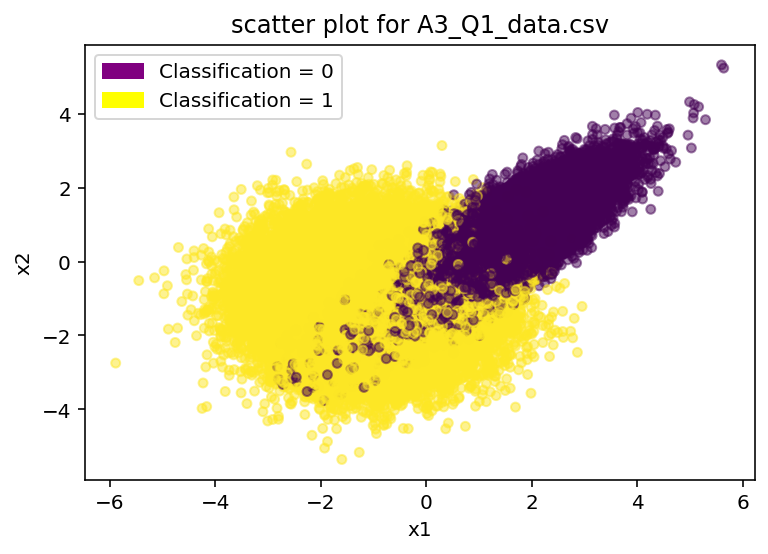

This data appear separable because we can see obvious clusters in the plot. 
Since the response variable is a binary classification, logistic regression would be a good choice for the data because we can estimate the probability of being classified as either of the categories.


In [177]:
A3_Q1_data = pd.read_csv("A3_Q1_data.csv")
plt.scatter('x1', 'x2', c = 'y', data = A3_Q1_data, s = 20, alpha = 0.5)
plt.title('scatter plot for A3_Q1_data.csv')
plt.xlabel('x1')
plt.ylabel('x2')
purple_patch = patches.Patch(color='purple', label='Classification = 0')
yellow_patch = patches.Patch(color='yellow', label='Classification = 1')
plt.legend(handles=[purple_patch, yellow_patch])
plt.show()

print('This data appear separable because we can see obvious clusters in the plot. \nSince the response variable is a binary classification, logistic regression would be a good choice for the data because we can estimate the probability of being classified as either of the categories.')

**(f)** Do the data require any preprocessing due to missing values, scale differences, etc? If so, how did you remediate this?

In [178]:
A3_Q1_data.isna().sum()

print("No. After using \'isna\' and sum function, we can confirm that there is no missing values in the dataset.")
print("Moreover, according to the scatter plot in (e), there is no scale differences and outliers with high leverage in the dataset as well.")

No. After using 'isna' and sum function, we can confirm that there is no missing values in the dataset.
Moreover, according to the scatter plot in (e), there is no scale differences and outliers with high leverage in the dataset as well.


#### Implement gradient descent and your logistic regression algorithm

**(g)** Create a function or class to implement your logistic regression. It should take as inputs the model parameters, $\mathbf{w}=\left[w_0,w_1,w_2\right]^{\intercal}$, and output the class confidence probabilities, $P(Y=y_i|X=\mathbf{x}_i)$.

**(h)** Create a function that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels.

**(i)** Create a function or class to run gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration (or "epoch") of the algorithm.  In doing this we'll need to make some assumptions about and/or experiment with the following:
1. The initialization of the algorithm - what should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
2. The learning rate - how slow/fast should the algorithm proceed in the direction opposite the gradient? This you will experiment with.
3. Stopping criteria - when should the algorithm be finished searching for the optimum? Set this to be when the cost function changes by no more than $10^{-6}$ between iterations. Since we have a weight vector, you can compute this by seeing if the L2 norm of the weight vector changes by no more than $10^{-6}$ between iterations.

Please compute your cost function for a batch as the average cost for the data in your current batch (in this case, a batch is your entire training dataset). In other words, divide your cost by the number of samples in each batch.

**(j)** Design your approach so that at each step in the gradient descent algorithm it will produce updated parameter estimates. For each set of estimates, calculate the cost function for both the training and the test data (no output is necessary here, but this is used in the following question).



In [179]:
class logis(object):
    def __init__(self):
        self.X = None
        self.y = None
        self.coef_ = None
        self.intercept_ = None
        self.w_hat = None
        self.l_rate = 0.00001
        self.stop_crit = pow(10, -6)
        self.threshold = 0.5
        
    def fit(self, X, y, l_rate = 0.00001):
        self.X = X
        self.y = y
        self.l_rate = l_rate
        # randomly assign w value
        np.random.seed(100)
        self.w_hat = np.random.rand(self.X.shape[1]+1)
        while True:
            w_pre = self.w_hat
            self.w_hat, c = self.gradient(w_pre)
            # check how much the L2 norm of weight vector changes 
            if  abs(np.linalg.norm(w_pre, ord = None) - np.linalg.norm(self.w_hat, ord = None) )< self.stop_crit:
                break
        self.intercept_ = self.w_hat[0]
        self.coef_ = self.w_hat[1:]
        pass
    
    def predict(self, X, w = None):
        X_ = np.insert(X, 0, 1, axis = 1)
        #calculate the possibility
        if w == None:
            p = 1/(1+ math.e **( - np.dot(X_, self.w_hat )))
        else:
            p = 1/(1+ math.e **( - np.dot(X_, w )))
        #calculate the predicted class
        y_hat = np.multiply( p > self.threshold, 1)
        return y_hat
        
    #(g)
    def predict_proba(self, X, w = None):
        X_ = np.insert(X, 0, 1, axis = 1)
        #calculate the possibility
        if w == None:
            p = 1/(1+ math.e **( - np.dot(X_, self.w_hat )))
        else:
            p = 1/(1+ math.e **( - np.dot(X_, w )))
        # calculate the probability for class = 0
        p = np.concatenate(((1 - p).reshape(-1,1), p.reshape(-1,1)), axis = 1)
        return p
    
    #(i)(j) 
    #one-time approach
    def gradient(self, w):
        w_pre = w
        X_ = np.insert(self.X, 0, 1, axis = 1)
        # do one-time gradient descent
        sigmoid = 1/(1+ math.e ** ((-1)*np.dot(X_, w_pre)) )
        grad = self.y * (-1) + sigmoid
        grad = grad.reshape(-1,1)
        grad = np.repeat(grad, (X_.shape[1]), axis = 1)
        grad = np.multiply( X_ , grad)
        # sum up the columns
        grad = grad.sum(axis = 0)
        self.w_hat = w_pre - self.l_rate* grad
        # calculate the cost
        c = self.cost()
        return self.w_hat, c

    def cost(self):
        X_ = np.insert(self.X, 0, 1, axis = 1)
        # calculate the "cost"
        c = np.dot(self.y, np.log( 1/(1 + math.e**( - np.dot(X_, self.w_hat ))))) + np.dot((1-self.y), np.log(1-(1/(1 + math.e**( - np.dot(X_, self.w_hat ))))))
        c = -c.sum()
        return c

    
def cost_func(X, y, w):
    # add 1s to the first column as x0 value
    X_ = np.insert(X, 0, 1, axis = 1)
    # calculate the "cost"
    c = np.dot(y, np.log( 1/(1 + math.e**( - np.dot(X_, w ))))) + np.dot((1-y), np.log(1-(1/(1 + math.e**( - np.dot(X_, w ))))))
    c = -c.sum()
    return c

**(k)** Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent. Show the gradient descent process for different learning rates by plotting the resulting cost as a function of each iteration (or "epoch"). What is the impact that each parameter has on the process and the results? What choices did you make in your chosen approach and why? Use the parameter you choose here for the learning rate for the remainder of this question. 

In [180]:
A3_Q1_data_np = np.genfromtxt("A3_Q1_data.csv", delimiter=',', skip_header =1)
X_train, X_test, y_train, y_test = train_test_split(A3_Q1_data_np[:, :2], A3_Q1_data_np[:, 2], test_size=0.30, random_state=42)

# use the same initial w 
np.random.seed(100)
w_ini = np.random.rand(X_train.shape[1]+1)
# learning rate
l_rate = [0.0001, 0.00001, 0.000005]
# create variables to use
logis_model = []
model_cost = []
iter_num = []

for i, rate in enumerate(l_rate):
    #fit the logis model
    logis_model.append(logis())
    logis_model[i].fit(X_train, y_train, rate)
    
    w_pre = w_hat = w_ini
    count = 0
    cost = []
    while True:
        w_pre = w_hat
        w_hat, c = logis_model[i].gradient(w_pre)
        cost.append(c)
        count += 1
        # check how much the L2 norm of weight vector changes 
        if  abs(np.linalg.norm(w_pre) - np.linalg.norm(w_hat) )< logis_model[i].stop_crit:
            model_cost.append(cost)
            iter_num.append(count)
            break

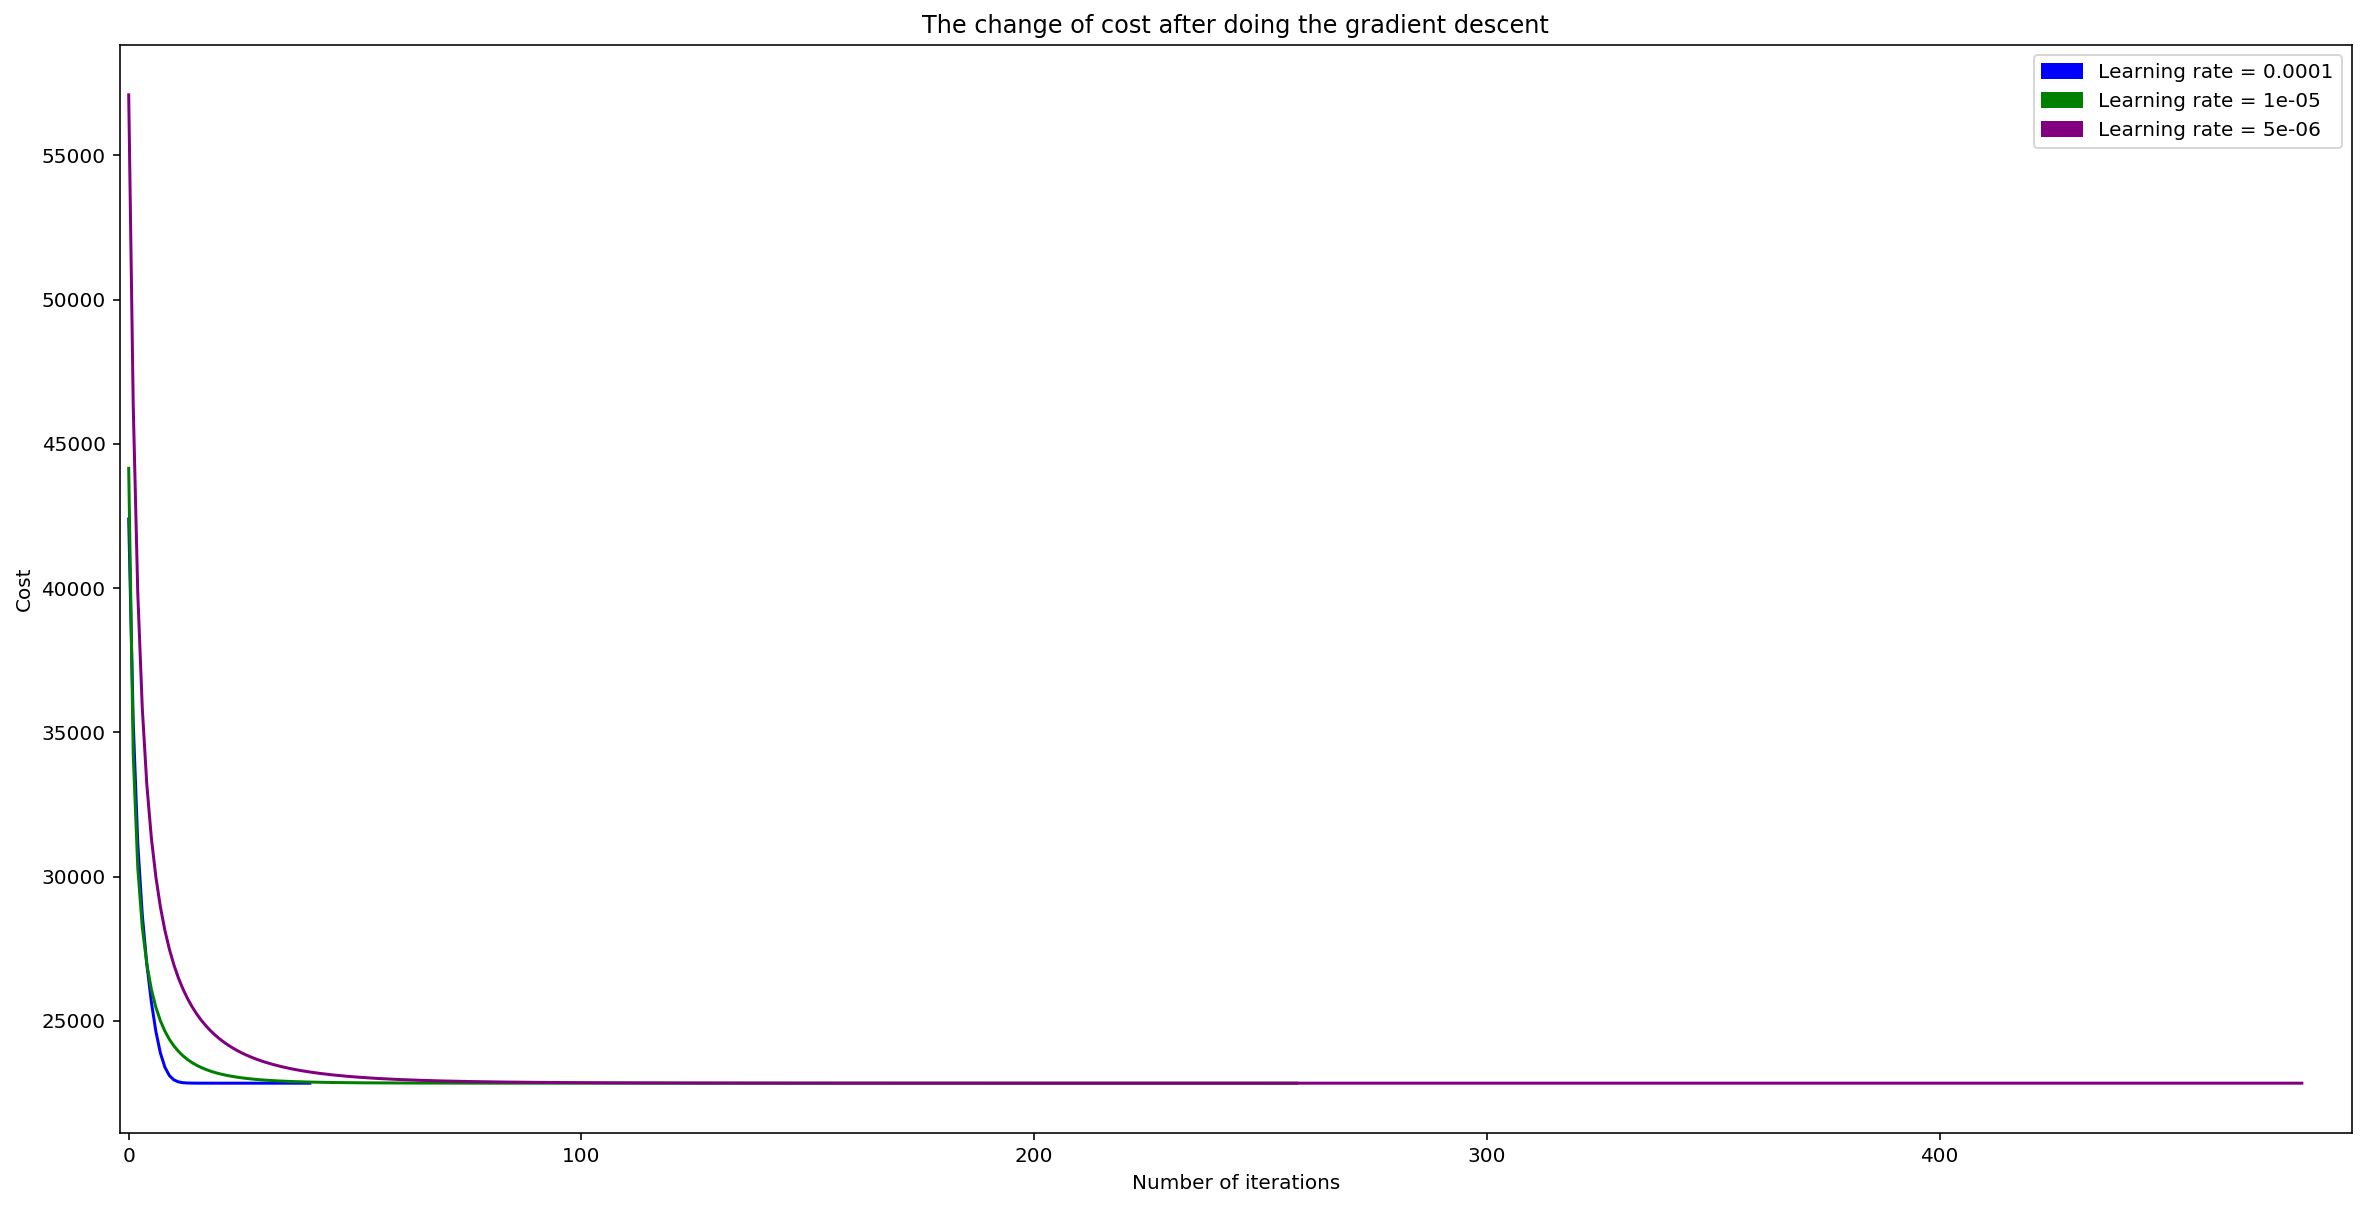

In [181]:
# plot the curve
# https://www.youtube.com/watch?v=weZIOjislr0
plt.figure(figsize=(20,10))

plt.plot(np.arange(0, iter_num[0]), model_cost[0], color = 'blue')
plt.plot(np.arange(0, iter_num[1]), model_cost[1], color = 'green')
plt.plot(np.arange(0, iter_num[2]), model_cost[2], color = 'purple')
plt.xlim([-2, max(iter_num) + 10])
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
blue_patch = patches.Patch(color='blue', label= f'Learning rate = {l_rate[0]}')
green_patch = patches.Patch(color='green', label=f'Learning rate = {l_rate[1]}')
purple_patch = patches.Patch(color='purple', label=f'Learning rate = {l_rate[2]}')
plt.legend(handles=[blue_patch, green_patch, purple_patch])
plt.title('The change of cost after doing the gradient descent')
plt.show()

Learning rates would affect the initial cost of the regression given the same random weights and how the cost would converge when  we do the gradient descent.   
The number of iteration would reduce/ increase the cost and finds the converged cost for the logistic regression.  
I would choose 0.0001 as my learning rate because the cost dropped drastically and the number of iterations needed for the cost to converge is the smallest.

#### Test your model performance through cross validation

**(l)** Test the performance of your trained classifier using K-folds cross validation (while this can be done manually, the scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful). Produce Receiver Operating Characteristic curves (ROC curves) of your cross validated performance. 

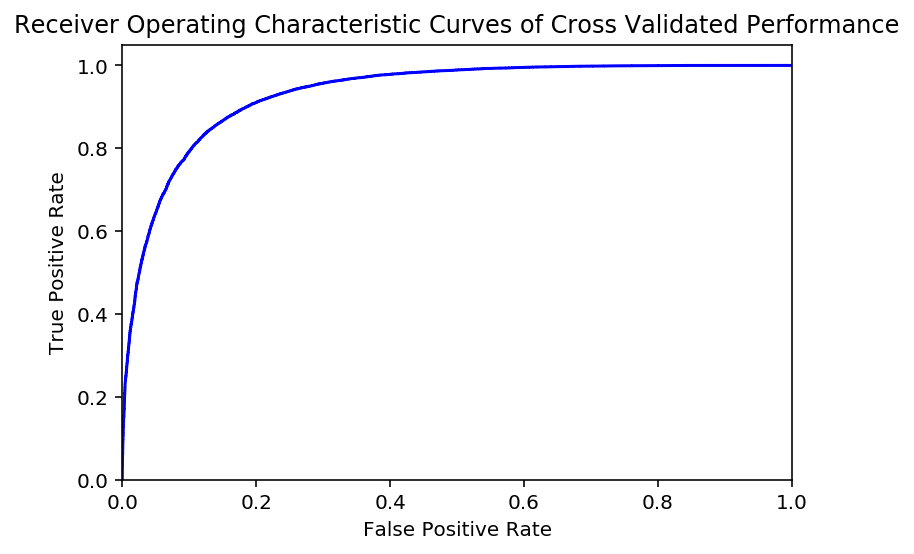

In [182]:
# one line for the combination of validation datasets
plt.figure()

# choose the learning rate which is the best
l_rate_best = l_rate[0]

skf = StratifiedKFold(n_splits=3)
# claim variables to save y & y_hat
y_true = []
y_proba = []

for train_index, test_index in skf.split(X_train, y_train):
    # separate the data
    X_train_f, X_test_f = X_train[train_index], X_train[test_index]
    y_train_f, y_test_f = y_train[train_index], y_train[test_index]
    # fit the logis model
    reg = logis()
    reg.fit(X_train_f, y_train_f, l_rate_best)
    # predict the y- value
    y_pro = reg.predict_proba(X_test_f)
    # save the y & predicted y value into the prepared list variable
    y_true.append(y_test_f)
    y_proba.append(y_pro[:,1])

# convert the list variable to numpy array
temp = y_true[0]
temp2 = y_proba[0]
for i in range(1,3):
    temp = np.concatenate((temp, y_true[i]), axis = None)
    y_true = temp
    temp2 = np.concatenate((temp2, y_proba[i]), axis = None)
    y_proba = temp2
y_true  = y_true.astype(int)

# plot the ROC curve on test data
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr, color = 'blue')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves of Cross Validated Performance')
plt.show()

**(m)** Why do we use cross validation?  
->Because we want to test how well the model is able to predict unknown data. By separating the training data into traning set and validation set, we can conduct the test on the validation set and get the idea.

**(n)** Make two plots - one of your training data, and one for your test data - with the data scatter-plot and the decision boundary for your classifier. Comment on your decision boundary. Could it be improved?

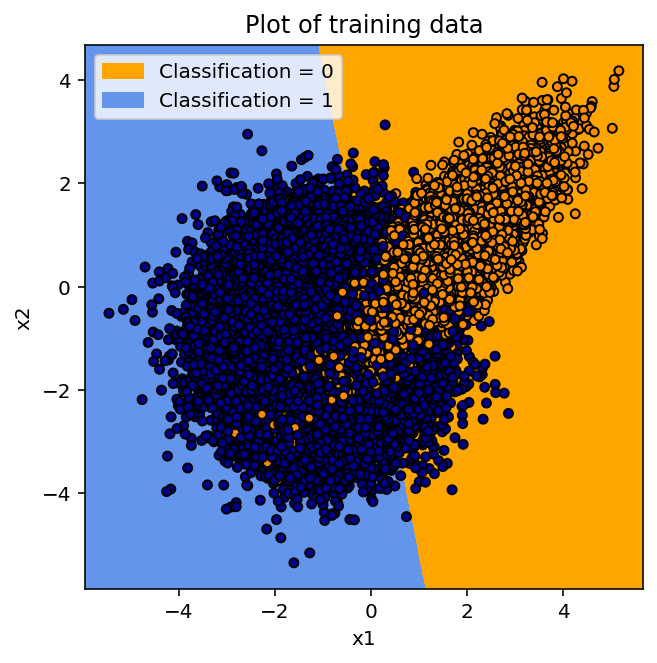

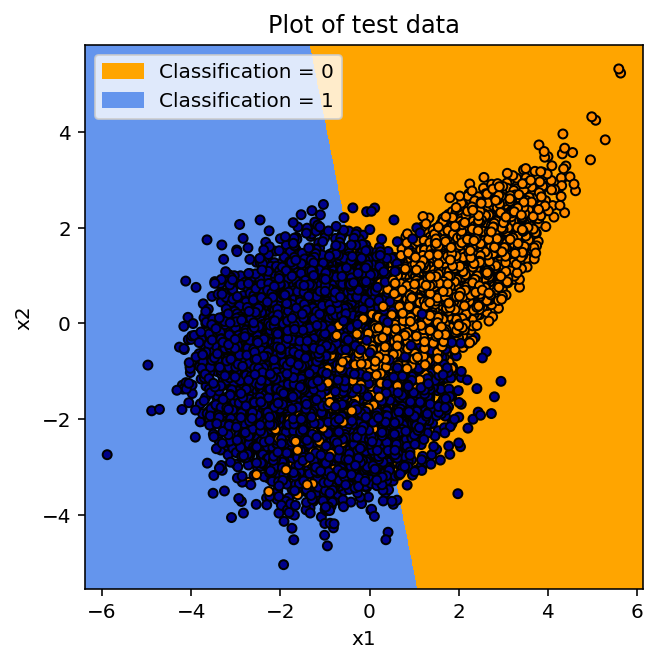

In [183]:
# fit logis model
reg = logis()
reg.fit(X_train, y_train, l_rate_best)

# Create color maps
cmap_light = ListedColormap(['orange', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

# plot for the training data
fig = plt.figure(figsize = [5,5])
# plot the decision boundary
mesh = np.meshgrid(np.arange(X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5, 0.01), np.arange(X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5, 0.01))
# calculate the predicted y value on the map
y_pred_train = reg.predict(np.c_[mesh[0].ravel(), mesh[1].ravel()])
# reshpe the predicted y value as matrix
y_pred_train = y_pred_train.reshape(mesh[0].shape)

# plot the background (decision boundary)
plt.pcolormesh(mesh[0], mesh[1], y_pred_train, cmap = cmap_light)

# plot the data points on the graph
plt.scatter(X_train[:, 0], X_train[:, 1], c= y_train, cmap=cmap_bold, edgecolor='k', s=20)
#add legend
orange_patch = patches.Patch(color='orange', label='Classification = 0')
cornflowerblue_patch = patches.Patch(color='cornflowerblue', label='Classification = 1')
plt.legend(handles=[orange_patch, cornflowerblue_patch])
# set the x & y axis
plt.xlim(X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5)
plt.ylim(X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5)
# set labels and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(f"Plot of training data")
plt.show()


# plot for the test data
fig = plt.figure(figsize = [5,5])
# plot the decision boundary
mesh = np.meshgrid(np.arange(X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5, 0.01), np.arange(X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5, 0.01))
# calculate the predicted y value on the map
y_pred_test = reg.predict(np.c_[mesh[0].ravel(), mesh[1].ravel()])
# reshpe the predicted y value as matrix
y_pred_test = y_pred_test.reshape(mesh[0].shape)

# plot the background (decision boundary)
plt.pcolormesh(mesh[0], mesh[1], y_pred_test, cmap = cmap_light)

# plot the data points on the graph
plt.scatter(X_test[:, 0], X_test[:, 1], c= y_test, cmap=cmap_bold, edgecolor='k', s=20)
#add legend
orange_patch = patches.Patch(color='orange', label='Classification = 0')
cornflowerblue_patch = patches.Patch(color='cornflowerblue', label='Classification = 1')
plt.legend(handles=[orange_patch, cornflowerblue_patch])
# set the x & y axis
plt.xlim(X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5)
plt.ylim(X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5)
# set labels and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(f"Plot of test data")
plt.show()

Since the boundary between the two classification is nonlinear, including predictor variables such as square of x1/x2 or cube of x1/x2 might give some flexibility to the decision boundary and improve our prediction on the data.

**(o)** Compare your trained model to random guessing. Show the ROC curve for your model and plot the chance diagonal. What area under the curve (AUC) does your model achieve? How does your model compare in terms of performance?

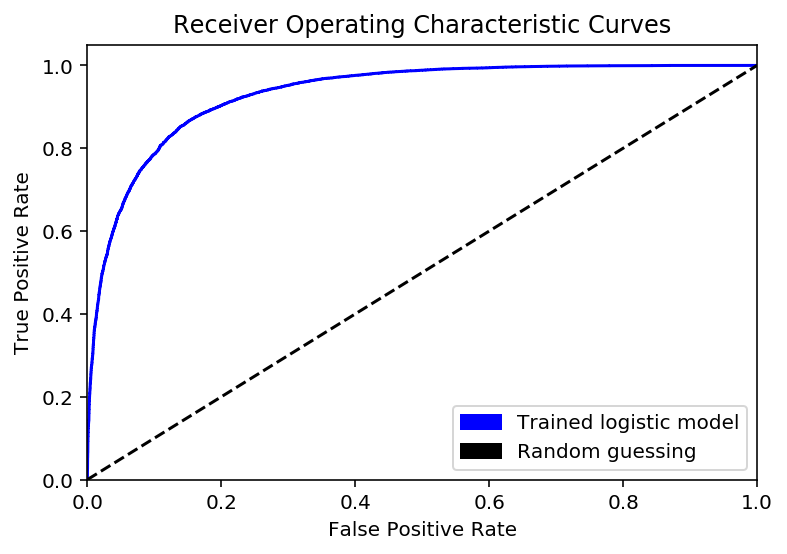

In [184]:
reg_o = logis()
reg_o.fit(X_train, y_train, l_rate_best)
y_proba_o = reg_o.predict_proba(X_test)

# plot the ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_proba_o[:,1])
plt.plot(fpr, tpr, color = 'blue')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
blue_patch = patches.Patch(color='blue', label= f'Trained logistic model')
black_patch = patches.Patch(color='black', label=f'Random guessing')
plt.legend(handles=[blue_patch, black_patch])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.show()

In [185]:
reg_o_auc = roc_auc_score(y_test, y_proba_o[:,1])
print(f"The AUC of my model on test data is {reg_o_auc:2f}.\nMy model performs well since the AUC is much larger than random guessing (0.5)")

The AUC of my model on test data is 0.932674.
My model performs well since the AUC is much larger than random guessing (0.5)


## 2

### [20 points] Digits classification

**ANSWER**  
**(a)** Construct your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, which has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.


Your goal is to determine whether or not an example is a 3, therefore your binary classifier will seek to estimate $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format. 

In [186]:
# load training data
fname_lbl = 'Q2/train-labels-idx1-ubyte'
fname_img = 'Q2/train-images-idx3-ubyte'

# Load everything in some numpy arrays
with open(fname_lbl, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    lbl = np.fromfile(flbl, dtype=np.int8)

with open(fname_img, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

# Print the images and labels to confirm correct output
#print(lbl.shape)
#print(img.shape)

# transform labels into a binary format y = 1 if digit is 3.
lbl_b = lbl.copy()
for idx, label in enumerate(lbl):
    if label == 3:
        lbl_b[idx] = 1
    else:
        lbl_b[idx] = 0

**(b)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.

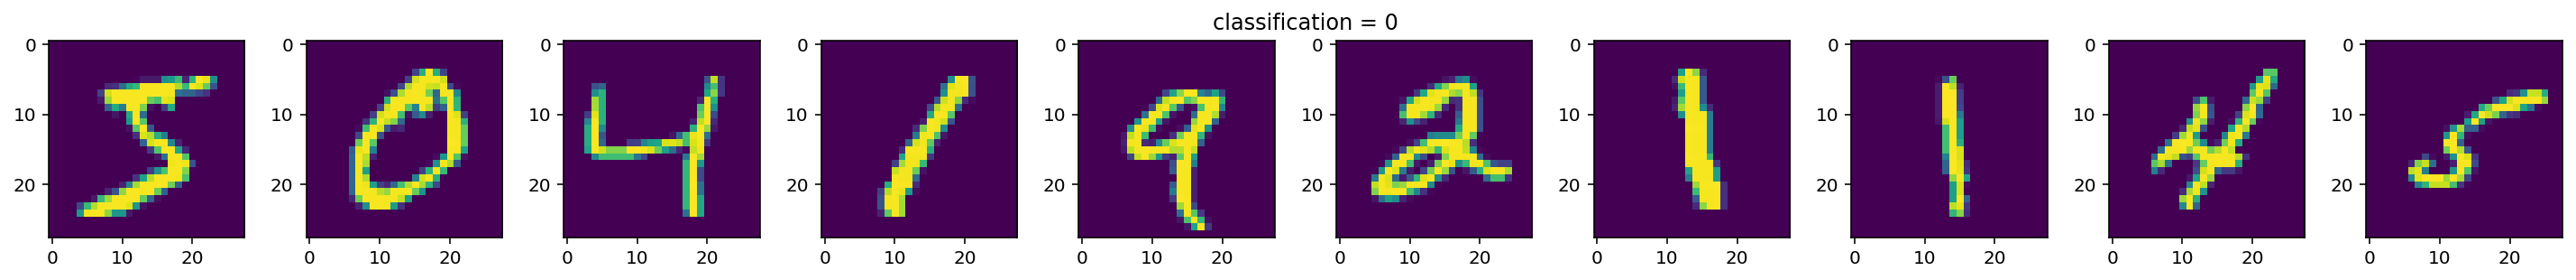

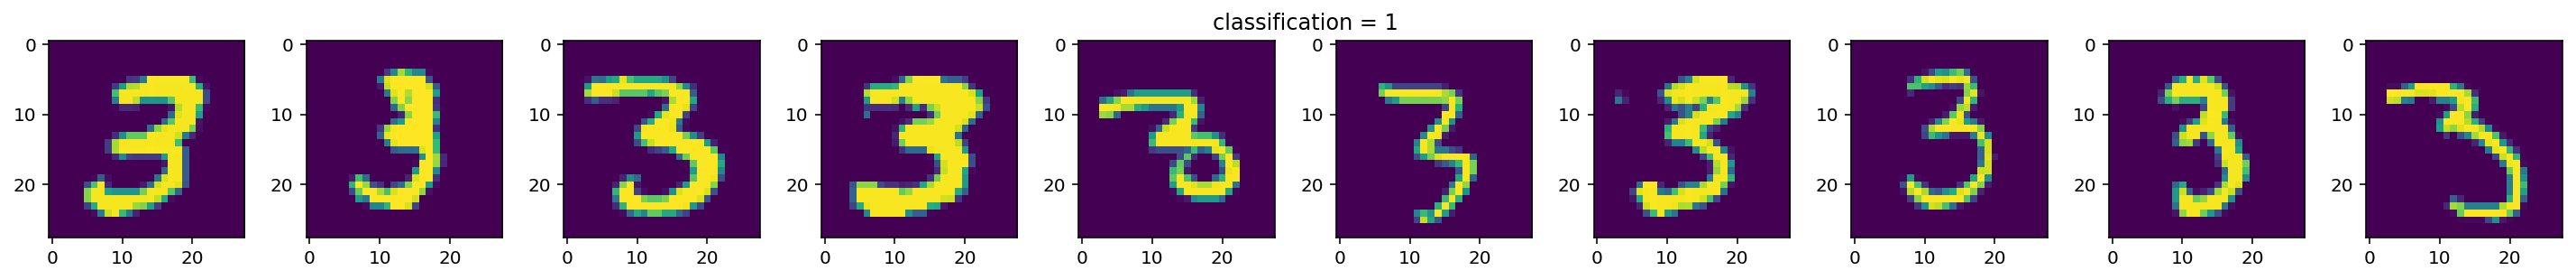

In [187]:
# get 10 examples of each class
img_ex_0 = []
img_ex_1 = []

for idx, c in enumerate(lbl_b):
    if len(img_ex_0) <10:
        if c == 0:
            img_ex_0.append(idx)
    if len(img_ex_1) < 10:
        if c == 1:
            img_ex_1.append(idx)
    if len(img_ex_0) == 10 & len(img_ex_1) == 10:
        break

#create a new figure    
fig = plt.figure(figsize = [25,2])
plt.title("classification = 0")
plt.axis('off')
# adjust the distance between figures
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# plot for classification = 0
for j in range(10):
    # seperate the figure into 1x10 smaller space to plot and plot in the jth subplot
    fig.add_subplot(1, 10, j+1)
    plt.imshow(img[img_ex_0[j]])

#create a new figure    
fig = plt.figure(figsize = [25,2])
plt.title("classification = 1")
plt.axis('off')
# adjust the distance between figures
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# plot for classification = 1
for j in range(10):
    # seperate the figure into 1x10 smaller space to plot and plot in the jth subplot
    fig.add_subplot(1, 10, j+1)
    plt.imshow(img[img_ex_1[j]])

**(c)** How many examples are present in each class? Show a histogram of samples by class. Are the classes balanced? What issues might this cause?

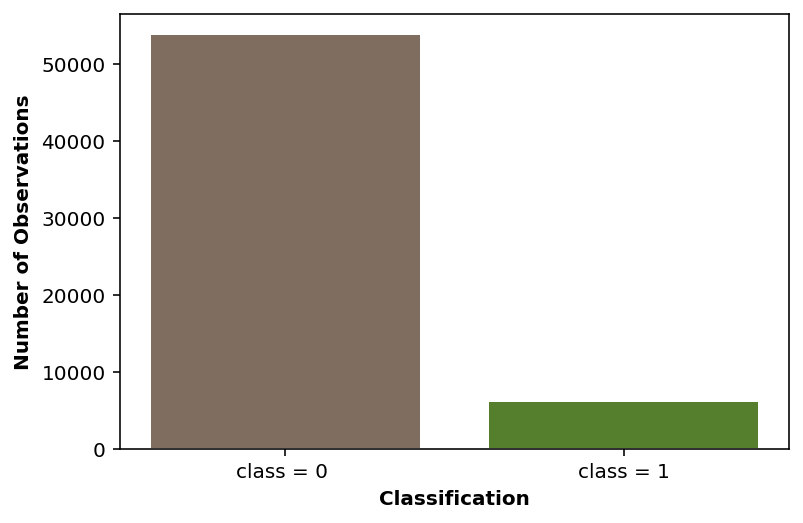

No, the classes are not balanced. 
There are only 10.218333% of the observations are classified as 1.
This would cause a problem that a model guessing all the data is 3 would perform well, which is not what we want to get.


In [188]:
# set width of bar
barWidth = 0.04
 
# set height of bar
c0 = len(lbl_b) - lbl_b.sum()
c1 = lbl_b.sum()
 
# Set position of bar on X axis
r1 = 1
r2 = 1.05
 
# Make the plot
plt.bar(r1, c0, color='#7f6d5f', width=barWidth, edgecolor='white', label='class = 0')
plt.bar(r2, c1, color='#557f2d', width=barWidth, edgecolor='white', label='class = 1')
 
# Add xticks on the middle of the group bars
plt.xlabel('Classification', fontweight='bold')
plt.ylabel('Number of Observations', fontweight='bold')
plt.xticks([1,1.05], ['class = 0 ', 'class = 1'])
plt.show()

print(f'No, the classes are not balanced. \nThere are only {(lbl_b.sum()/len(lbl_b))*100:f}% of the observations are classified as 1.')
print('This would cause a problem that a model guessing all the data is 3 would perform well, which is not what we want to get.')

**(d)** Using cross-validation, train and test a classifier. Compare your performance against (1) a classifier that randomly guesses the class, and (2) a classifier that guesses that all examples are NOT 3's. Plot corresponding ROC curves and precision-recall curves. Describe the algorithm's performance and explain any discrepancies you find.

In [189]:
# set how many fold do we want to use
skf = StratifiedKFold(n_splits=3)

# reshape the X data in order to fit the model
img_reshape = img.reshape((len(img), len(img[0])**2))

In [190]:
# I use logistic model with penalty L2 to answer this question.
# claim variables to save the accuracy of each k-fold model
y_true = []
y_proba = []

# do k-fold cross-validation for logistic regression
for train_idx, test_idx in skf.split(img_reshape, lbl_b):
    X_train, X_test = img_reshape[train_idx], img_reshape[test_idx]
    y_train, y_test = lbl_b[train_idx], lbl_b[test_idx]
    
    classifier = LogisticRegression().fit(X_train, y_train)
    
    # predict the test data
    y_pro = classifier.predict_proba(X_test)
    # save the y & predicted y value into the prepared list variable
    y_true.append(y_test)
    y_proba.append(y_pro[:,1])
    
# convert the list variable to numpy array
temp = y_true[0]
temp2 = y_proba[0]
for i in range(1,3):
    temp = np.concatenate((temp, y_true[i]), axis = None)
    y_true = temp
    temp2 = np.concatenate((temp2, y_proba[i]), axis = None)
    y_proba = temp2
y_true  = y_true.astype(int)

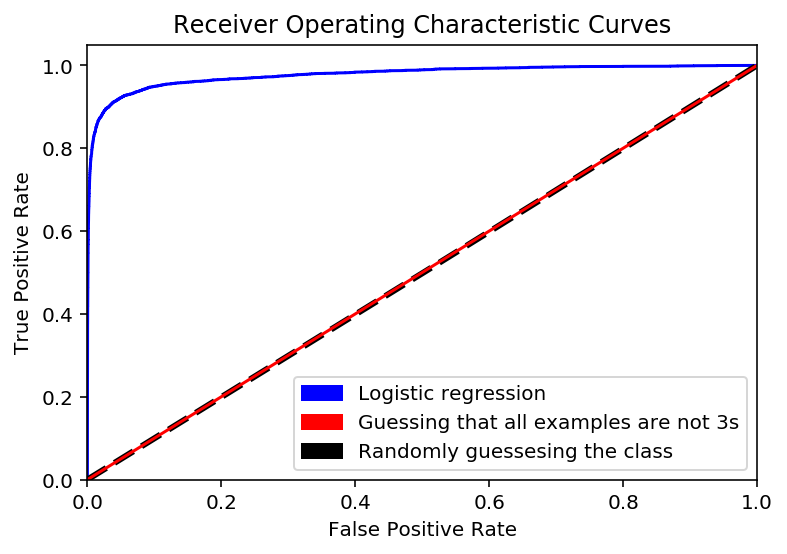

In [191]:
#plot the roc curves using whole training data

# plot the classifier applied cross-validation
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr, color = 'blue')

# plot classifier randomly guess the class
np.random.seed(100)
y_ran_prob = np.random.choice([0,1], size=len(lbl_b), replace=True, p=[0.5, 0.5])
fpr, tpr, _ = roc_curve(lbl_b, y_ran_prob)
plt.plot(fpr, tpr, color='black', linestyle='--', linewidth=3)

# plot classifier guess that all examples are not 3s
y_hat_not3 = np.zeros(len(lbl_b))
fpr, tpr, _ = roc_curve(lbl_b, y_hat_not3)
plt.plot(fpr, tpr, color = 'red', linestyle='-')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
blue_patch = patches.Patch(color='blue', label='Logistic regression')
red_patch = patches.Patch(color='red', label='Guessing that all examples are not 3s')
black_patch = patches.Patch(color='black', label='Randomly guessesing the class')
plt.legend(handles=[blue_patch, red_patch, black_patch])
plt.title('Receiver Operating Characteristic Curves')
plt.show()

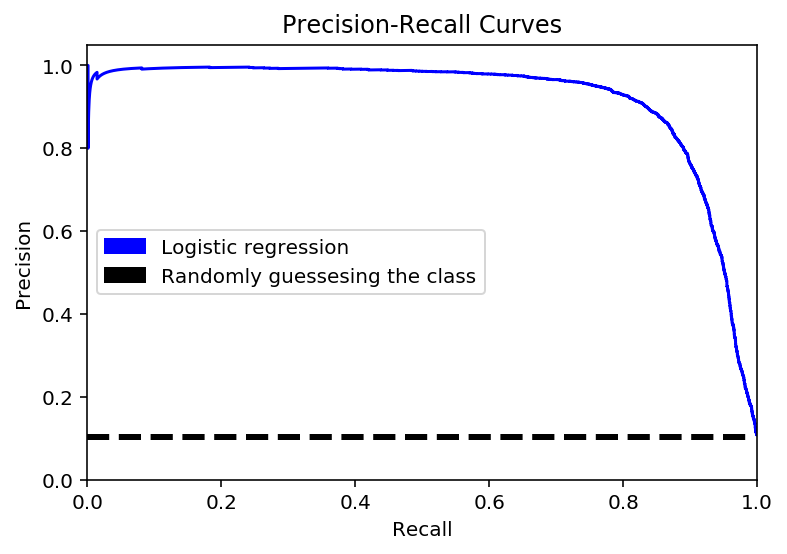

In [192]:
# plot the precision-recall curves
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

plt.figure()

# plot the classifier applied cross-validation
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
plt.plot(recall, precision, color = 'blue')

# plot classifier randomly guess the class
pre = np.zeros(100)
pre[:] = lbl_b.sum() / len(lbl_b)
plt.plot(np.arange(0,1,0.01), pre , color='black', linestyle='--', linewidth=3)

blue_patch = patches.Patch(color='blue', label='Logistic regression')
black_patch = patches.Patch(color='black', label='Randomly guessesing the class')
plt.legend(handles=[blue_patch, black_patch])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.show()

The randomly guessing the class would be a horizontal line with   
the precision value =  the number of observations that the true classification = 1 divided by the number of observations  
proof:  
Let   
$\alpha$ = the proportion of observations that the classification is 1  
$\beta$ = the proportion of observations that the classification is 0  
p = the output probability of class 1   
By defination:    
$
recall = \frac{TP}{TP + FN} = \frac{\alpha p}{\alpha p + \alpha(1-p)} = p \\
precision = \frac{TP}{TP+FP} = \frac{\alpha p}{\alpha p + \beta p} = \frac{\alpha}{\alpha + \beta} \\
$  
, which the precision is a constant.

About the model that guessing that all examples are not 3s, there is no point to show in the PR curve plot.  
proof:  
Let   
$\alpha$ = the proportion of observations that the classification is 1  
By defination and since we guess all the classification to be 0:  
$
recall = \frac{TP}{TP + FN} = \frac{0}{0 + \alpha} = 0\\
precision = \frac{TP}{TP+FP} = \frac{0}{0+0} = 0\\
$  
, which precision is undefined.

The algorithm performance outstands both random guessing.  
However, between the ROC curve and the PR curve, there is a discrepancy.  
In the PR curve, when the value of recall near to 0, the precision is starting from 0.8. When the recall gets larger, it once grows to 1, then starts to decrease. This kind of trend is not seen in the ROC curve.

**(f)** Using a logistic regression classifier (a linear classifier), apply lasso regularization and retrain the model and evaluate its performance over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module (DO NOT use your function from question 1) and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. As you vary the regularization coefficient, plot (1) the number of model parameters that are estimated to be nonzero; (2) the logistic regression cost function, which you created a function to evaluate in the Question 1; (3) $F_1$-score, and (4) area under the curve (AUC). Describe the implications of your findings.

In [193]:
# fit logistic regression applying lasso with the Inverse of regularization strength C

X_train_2f, X_test_2f, y_train_2f, y_test_2f = train_test_split(img_reshape, lbl_b, test_size=0.30, random_state=42)

# create C values
C_values = np.arange(0.1, 1, 0.1)
# create empty lists to record what we need to plot
# number of nonzero parameters
C_count_para = []
# the cost of logistic regressions
C_cost = []
#the F1-score of logistic regressions
C_f1 = []
# AUC of logistic regressions
C_auc = []

for c in C_values:
    #fit the logistic regression using different C value
    reg = LogisticRegression(penalty='l1', C = c).fit(X_train_2f, y_train_2f)
    #count the number of nonzero parameters in the model
    count = (reg.coef_ != 0).sum() + (reg.intercept_ != 0).sum()
    #save the number to a list
    C_count_para.append(count)
    
    #calculate the cost for the logistic regression
    #concatenate the parameter of the model
    w = np.concatenate((reg.intercept_.reshape(-1,1), reg.coef_), axis = 1).reshape(-1,1)
    # calculate the cost
    y_score = reg.predict_proba(X_test_2f)
    #C_cost.append(log_loss(y_test_2f, y_score, normalize = False))
    C_cost.append(cost_func(X_test_2f, y_test_2f, w) )
    
    #calculate the F1-score
    y_pred = reg.predict(X_test_2f)
    C_f1.append(f1_score(y_test_2f, y_pred))
    
    #calculate the AUC
    y_score = reg.predict_proba(X_test_2f)
    C_auc.append(roc_auc_score(y_test_2f, y_score[:, 1]))
    #roc_auc_score(y_true, y_score)


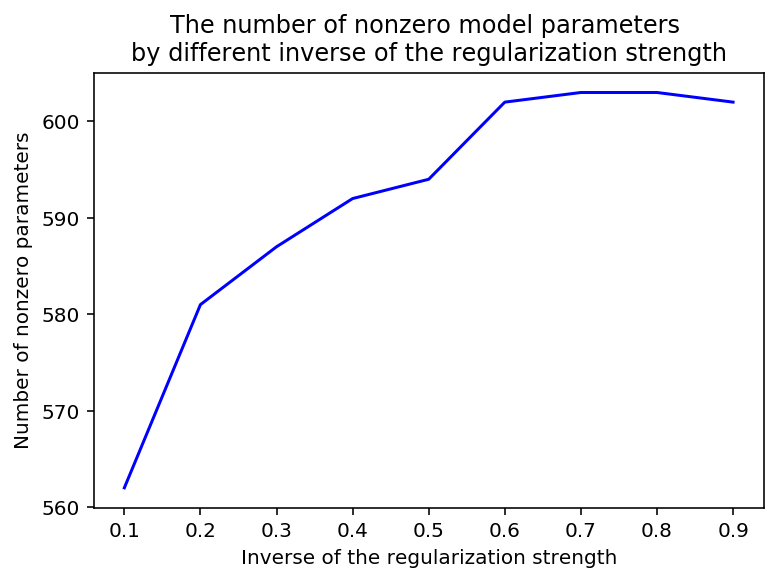

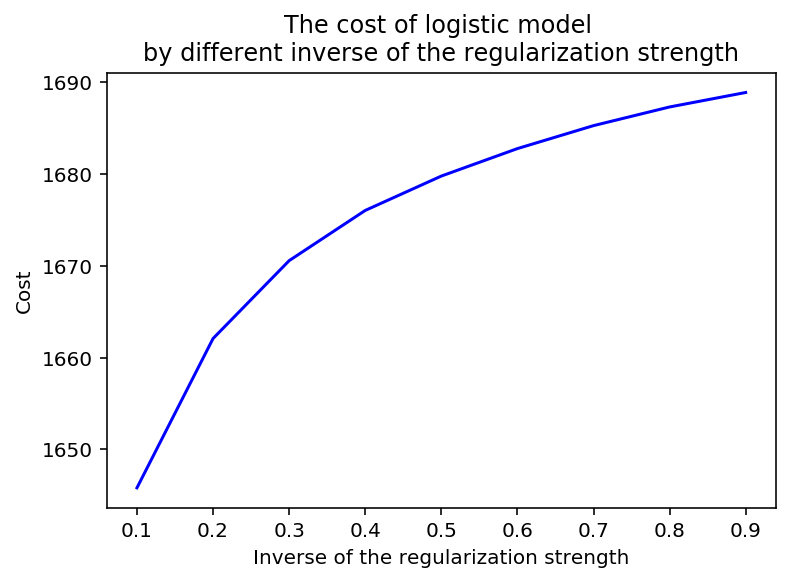

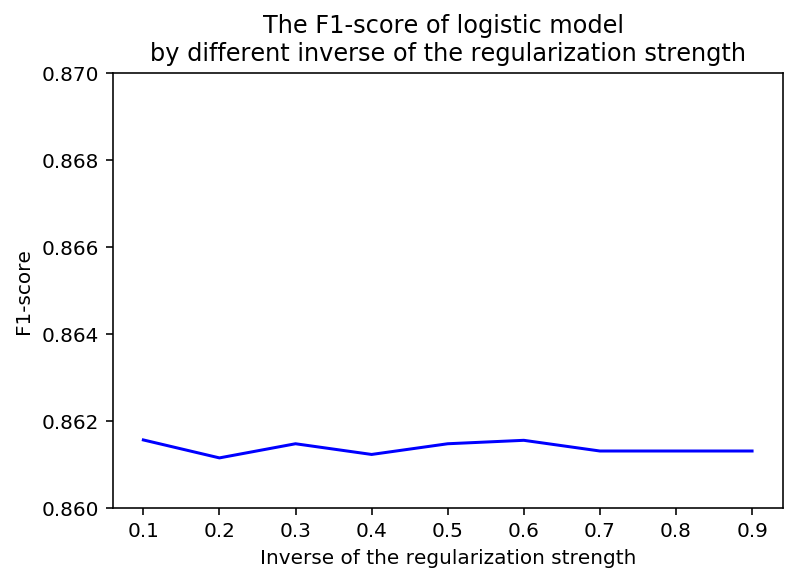

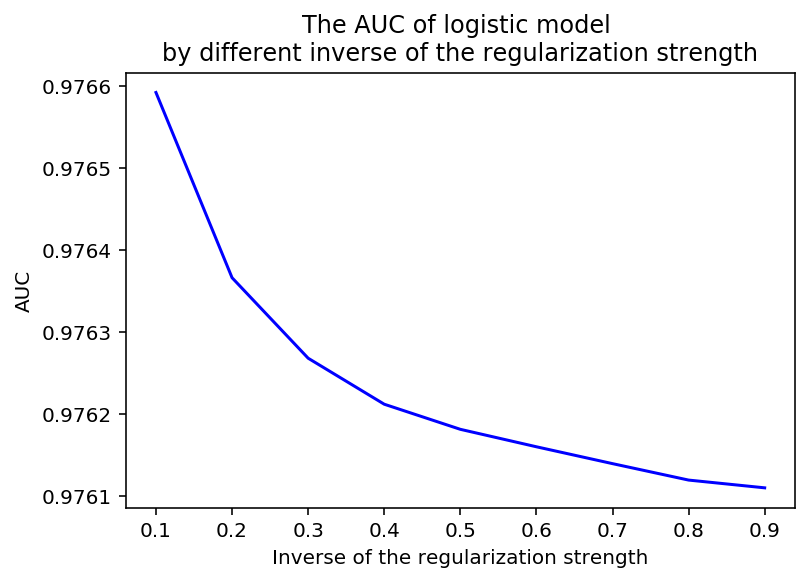

In [194]:
#(1)  plot the number of nonzero parameters for each C value
plt.plot(C_values, C_count_para, color = 'blue')
plt.title("The number of nonzero model parameters \nby different inverse of the regularization strength")
plt.xlabel('Inverse of the regularization strength')
plt.ylabel('Number of nonzero parameters')
plt.show()

#(2) plot the cost for each C value
plt.plot(C_values, C_cost, color = 'blue')
plt.title("The cost of logistic model \nby different inverse of the regularization strength")
plt.xlabel('Inverse of the regularization strength')
plt.ylabel('Cost')
plt.show()

#(3) plot the F1-score for each C value
plt.plot(C_values, C_f1, color = 'blue')
plt.title("The F1-score of logistic model \nby different inverse of the regularization strength")
plt.ylim([0.86, 0.87])
plt.xlabel('Inverse of the regularization strength')
plt.ylabel('F1-score')
plt.show()

#(4) plot AUC value for each C value
plt.plot(C_values, C_auc, color = 'blue')
plt.title("The AUC of logistic model \nby different inverse of the regularization strength")
plt.xlabel('Inverse of the regularization strength')
plt.ylabel('AUC')
plt.show()

Even if we only set the regularization strength a little bit larger (which means C would be smaller), we can reduce the number of nonzero model parameters a lot, with the cost, F1-score, and AUC almost keeps the same. This fact is very useful when we have lots of features in the model and we can select the important features by simply applying different regularization values.

## 3

### [10 points] Comparing the Bayes' decision rule with logistic regression

The phrase "Bayes' decision rule" is often used to describe a classifier decision rule that minimizes misclassification rate (equally penalizing false positives and false negatives). In this exercise you will first determine the Bayes's decision rule for a binary classification problem where you know the likelihood of date from each class. The binary classification problem has two classes with data distributed as exponential random variables:

$$P(x|C_i) = \lambda_i e^{-\lambda_i x}$$

Where $C_i$ represents the class from which the sample is drawn (0 or 1). We also know that $\lambda_0 = 1$ and $\lambda_1 = 5$.




**ANSWER**  
**(a)** Plot the probability of each class conditional distribution (e.g. likelihood function), $P(x|C_0)$ and $P(x|C_1)$ on the sample plot in the domain $x \in [0,2]$. *You can use [`scipy`'s `expon` module](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon) for this. Note that the `scale` parameter for this module is defined as $1/\lambda$.*

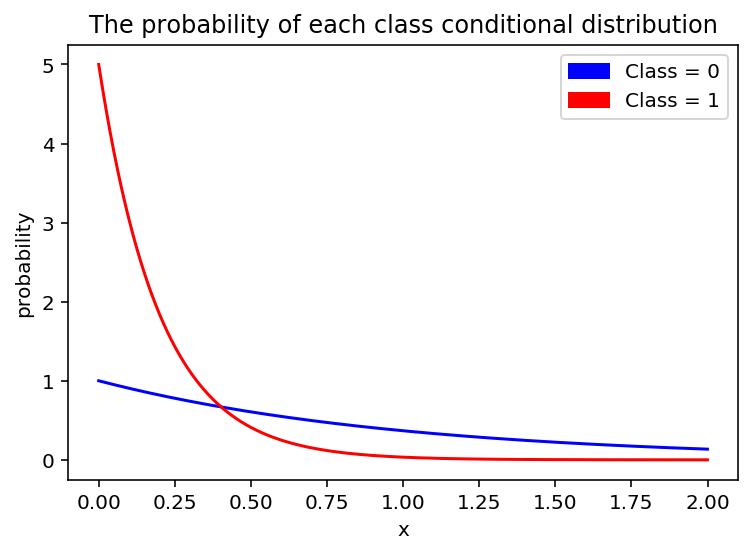

In [195]:
x_q3 = np.arange(0,2, 0.0005)
p_c0 = expon.pdf(x_q3, scale = 1)
p_c1 = expon.pdf(x_q3, scale = 1/5)

# draw the line of C = 0
plt.plot(x_q3, p_c0, color = 'blue')
# draw the line of C = 1
plt.plot(x_q3, p_c1, color = 'red')

# set the legends
blue_patch_linear = patches.Patch(color='blue', label='Class = 0')
red_patch_linear = patches.Patch(color='red', label='Class = 1')
plt.legend(handles=[blue_patch_linear, red_patch_linear])
# set labels and title
plt.xlabel('x')
plt.ylabel('probability')
plt.title("The probability of each class conditional distribution")
plt.show()

**(b)** Assuming the prior class distributions are $P(C_0)=P(C_1)=0.5$, determine the Bayes' decision rule using the information above including the posterior distributions and the prior distributions. You will assign the most probable class to the data based on the value of $x$. The decision rule will be of the form: 

If $x > x^*$, then predict Class 0, otherwise predict Class 1

Determine the value $x^*$ that minimizes misclassification (equally penalizing false positives and false negatives, and no penalty/reward for correct detections). Show your work in deriving this value.  

-> When $P(C_i = C_0 | x_i) > P(C_i = C_1 = x_i)$, we predict $\hat{y}$ = C_0, otherwise we predict $\hat{y}$ = C_1  
Based on Bayes' theorem:  
$
P(C_i = C_0 | x_i) > P(C_i = C_1 = x_i) \\
\Longrightarrow \frac{P(x_i | C_i = C_0)P(C_0)}{P(x)} > \frac{P(x_i | C_i = C_1)P(C_1)}{P(x)} \\
\Longrightarrow P(x_i |C_i = C_0) > P(x_i | C_i = C_1) \\
\Longrightarrow e^{-x} > 5 e^{-5x} \\
\Longrightarrow \frac{e^{-x}}{e^{-5x}} > 5 \\
\Longrightarrow e^{4x} > 5 \\
\Longrightarrow x = \frac{\ln 5}{4} \\
\Longrightarrow x* = 0.40235947810852507 \\
$

**(c)** How does your answer in (b) relate to the the plot you made in (a)? Why?  
->My answer in (b) is the x value where the two probability distribution line intersect with each other.

**(d)** Load the test data in the file `A3_Q3_test.csv`. Apply your decision rule to the data. What is the misclassification rate (error rate, or fraction of misclassified samples) of this decision rule?

In [196]:
A3_Q3_test = pd.read_csv('A3_Q3_test.csv', usecols = [1,2])
A3_Q3_test['y_hat'] =  1
A3_Q3_test.loc[A3_Q3_test['x'] > 0.402, 'y_hat'] = 0
A3_Q3_test
error_rate = (A3_Q3_test['y'] != A3_Q3_test['y_hat'] ).sum()/len(A3_Q3_test)
print(f"The error rate is {error_rate}")

The error rate is 0.234


**(e)** Load the training data in the file `A3_Q3_train.csv` and train a logistic regression classifier on the data (using default parameters). What is your misclassification error for your test dataset? How does this compare with the Bayes' classifier?

In [197]:
A3_Q3_train = np.genfromtxt('A3_Q3_train.csv', delimiter=',', skip_header =1, usecols=(1,2))
reg = LogisticRegression().fit(A3_Q3_train[:, 0].reshape(-1,1), A3_Q3_train[:, 1])
print(f"The misclassification error is {round(1 - reg.score(A3_Q3_train[:, 0].reshape(-1,1), A3_Q3_train[:, 1]), 3)}")
print("The misclassification error is a same as the Bayes' classifier. ")

The misclassification error is 0.234
The misclassification error is a same as the Bayes' classifier. 


**(f)** What is your decision rule for your logistic regression model? To compute this, extract the parameters from your fit model (look for the `coef_` and `intercept_` attributes) and since the classes are balanced, the decision rule will be to classify a sample $x$ as Class 1 when your logistic regression sigmoid is greater than 0.5 (the halfway point from the two extremes of 0 and 1). How does this compare with the Bayes' classifier?   
->
$
\sigma(x) = \frac{1}{1+ e^{-x}} \\
\Longrightarrow \frac{1}{1+ e^{-(W^Tx)}} > 0.5 \\
\Longrightarrow e^{-(w^Tx)} = 1 \\
\Longrightarrow -(W^Tx) = 0 \\
\Longrightarrow \beta_0 + \beta x = 0 \\
\Longrightarrow x = \frac{-\beta_0}{\beta_1} \\
$

In [198]:
print(f"The coefficient of the logistic model: {reg.coef_[0,0]:2f}")
print(f"The intercept of the logistic model: {reg.intercept_[0]:2f}")
print(f"The decision rule for my logistic regression model is if x > {abs(reg.intercept_/reg.coef_)[0][0]}, it would be classified as 0")
print("The x value is a little bit higher than the Bayes' classifier.")

The coefficient of the logistic model: -3.975294
The intercept of the logistic model: 1.603363
The decision rule for my logistic regression model is if x > 0.40333195143056744, it would be classified as 0
The x value is a little bit higher than the Bayes' classifier.


**(g)** If the prior probabilities were not $P(C_0)=P(C_1)=0.5$, but instead if $P(C_1)>P(C_0)$. How would this impact the optimal decision rule? Would it change, if so, would $x^*$ be larger or smaller?   
-> As mentioned in (b), when $P(C_i = C_0 | x_i) > P(C_i = C_1 = x_i)$, we predict $\hat{y} = C_0$ , otherwise we predict $\hat{y} = C_1$  
Based on Bayes' theorem:  
$
P(C_i = C_0 | x_i) > P(C_i = C_1 | x_i) \\
\Longrightarrow \frac{P(x_i | C_i = C_0)P(C_0)}{P(x)} > \frac{P(x_i | C_i = C_1)P(C_1)}{P(x)} \\
$  
However, now $P(C_0) \neq P(C_1)$.  
Therefore,  
$
\Longrightarrow P(C_0)P(x_i |C_i = C_0) > P(C_1)P(x_i | C_i = C_1) \\
\Longrightarrow P(C_0)e^{-x} > P(C_1)5 e^{-5x} \\
\Longrightarrow \frac{P(C_0)}{P(C_1)} > 5e^{-4x} \\
\Longrightarrow \ln (\frac{P(C_0)}{P(C_1)}) > \ln 5 - 4x \\
\Longrightarrow x > \frac{1}{4} [\ln 5 - \ln [\frac{P(C_0)}{P(C_1)}]]\\
$  

The x* value would change depends on the value of $\ln [\frac{P(C_0)}{P(C_1)}]$.   
Under the situation that $P(C_1)>P(C_0)$, the x* value would be larger than the x* value I got based on bayes' theorem.

In [199]:
# write code to try if the x* value would become larger.
for i in range(int(2/0.0005)):
    # if the prior probability is [0.3, 0.7]
    if abs(0.3*p_c0[i] - 0.7*p_c1[i]) < 0.001:
        x_t = i*0.0005
        break
print(f"x* = {x_t} > 0.402")

x* = 0.613 > 0.402


## 4

### [30 points] Supervised learning exploration

For this exercise, you will construct and implement a supervised learning problem solution/experiment. Describe your process and answer these questions clearly and thoroughly. Part of the grade in this assignment is devoted to the quality and professionalism of your work.

*This grade for this question is based on (a) the completeness of the answer in addressing each of the above components, (b) the quality of the work and accuracy of the interpretation of the results of the analysis, (c) the presentation and professionalism of the work, and (d) the amount of creativity demonstrated by the work.*

**ANSWER**  
Data used in this question: https://github.com/JingchunCheng/All-Age-Faces-Dataset

**(a)** Identify a question or problem that's of interest to you and that could be addressed using classification or regression. Explain why it's interesting and what you'd like to accomplish. You're encouraged to be creative.  
-> I am curious about how accurate that a computer program can predict gender based on images. When I was in undergra

**(b)** Download the data and plot the data to describe it. You can use any dataset of interest to you with the exception of the Iris dataset, the Kaggle Titanic dataset, or the Kaggle chocolate dataset. Possible sources of dataset include (but are not limited to):

- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)
- [Kaggle Datasets](https://www.kaggle.com/datasets)
- [Amazon Open Datasets](https://registry.opendata.aws/)
- [Microsoft's Open Data](https://msropendata.com/)
- [Google's Dataset Search](https://datasetsearch.research.google.com/)
- [Awesomedata's list of datasets](https://github.com/awesomedata/awesome-public-datasets)

In [200]:
# load data

# labels
label_train = pd.read_table("/Users/yu/Documents/Duke/courses/20spring/IDS705 ML/HW/assignment3/All-Age-Faces Dataset/image sets/train.txt", header = None, sep = ' ')
label_vali = pd.read_table("/Users/yu/Documents/Duke/courses/20spring/IDS705 ML/HW/assignment3/All-Age-Faces Dataset/image sets/val.txt", header = None, sep = ' ')

#combine them to one dataframe
frame = [label_train, label_vali]
label_gender = pd.concat(frame, axis = 0)
# sort by image names
label_gender = label_gender.sort_values(by = [0]).reset_index(drop = True)
# save the name list for loading features
file_list = label_gender[0].to_numpy().astype(str)
# delete the first column
label_gender = label_gender.drop([0], axis = 1)
# convert to numpy array
label_gender = label_gender.to_numpy()

# features
dir_keypoints  = '/Users/yu/Documents/Duke/courses/20spring/IDS705 ML/HW/assignment3/All-Age-Faces Dataset/key points/'
# one for drawing one for fit model
keypoints = []
keypoints_flat = []

for name in file_list:
    fname     = dir_keypoints + name[:-3] + 'txt'
    # read the keypoints 
    key_p = np.genfromtxt(fname, delimiter=' ')
    keypoints.append(key_p)
    # read the keypoints and flatten the features, make it the form to fit model
    key_p_f     = np.genfromtxt(fname, delimiter=' ').ravel().transpose()
    keypoints_flat.append(key_p_f)
    
# Convert to Numpy array
keypoints = np.array(keypoints) 
keypoints_flat = np.array(keypoints_flat) 

This dataset contains 49 keypoints on the face for each image, with labels of gender and age.
A model of predicting gender or age by these keypoints can be trained by this dataset.


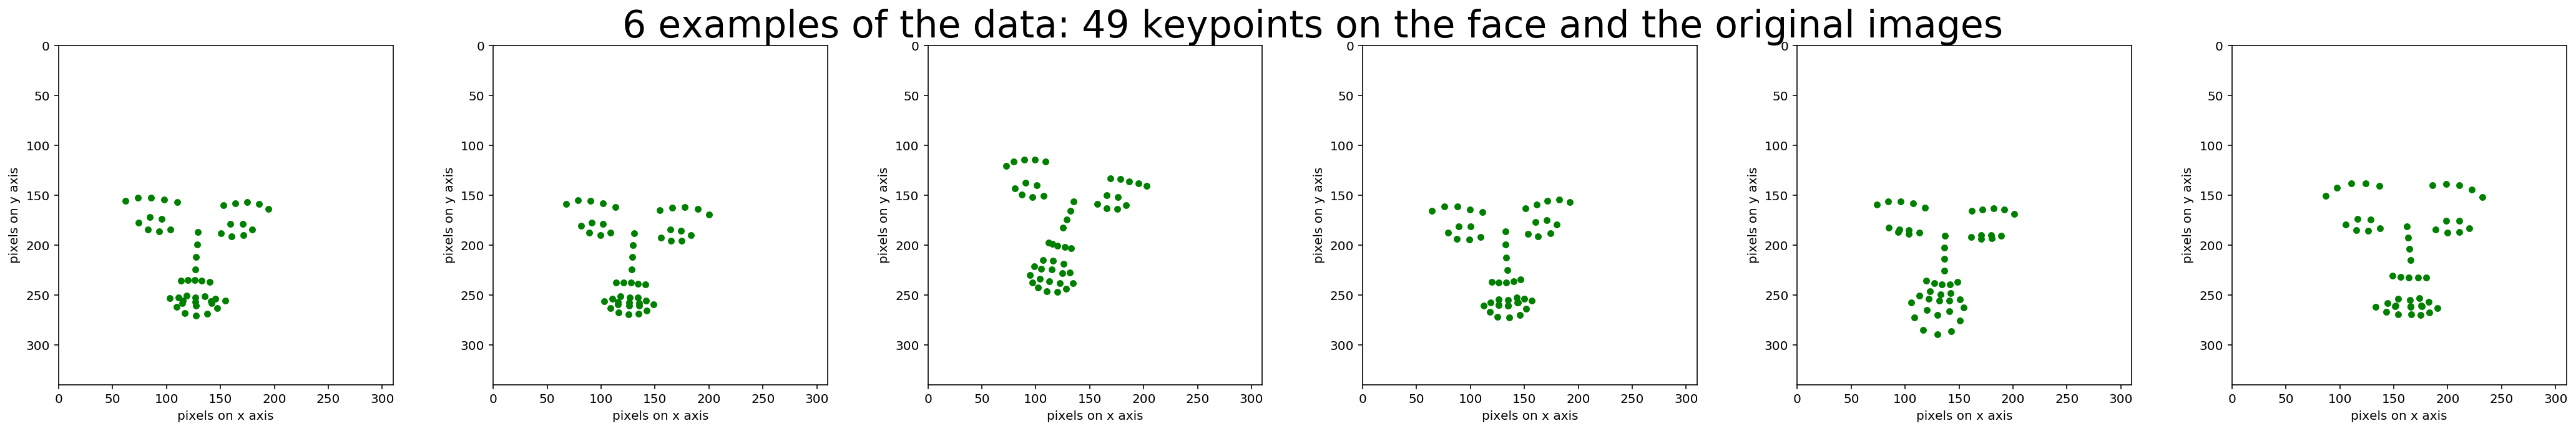

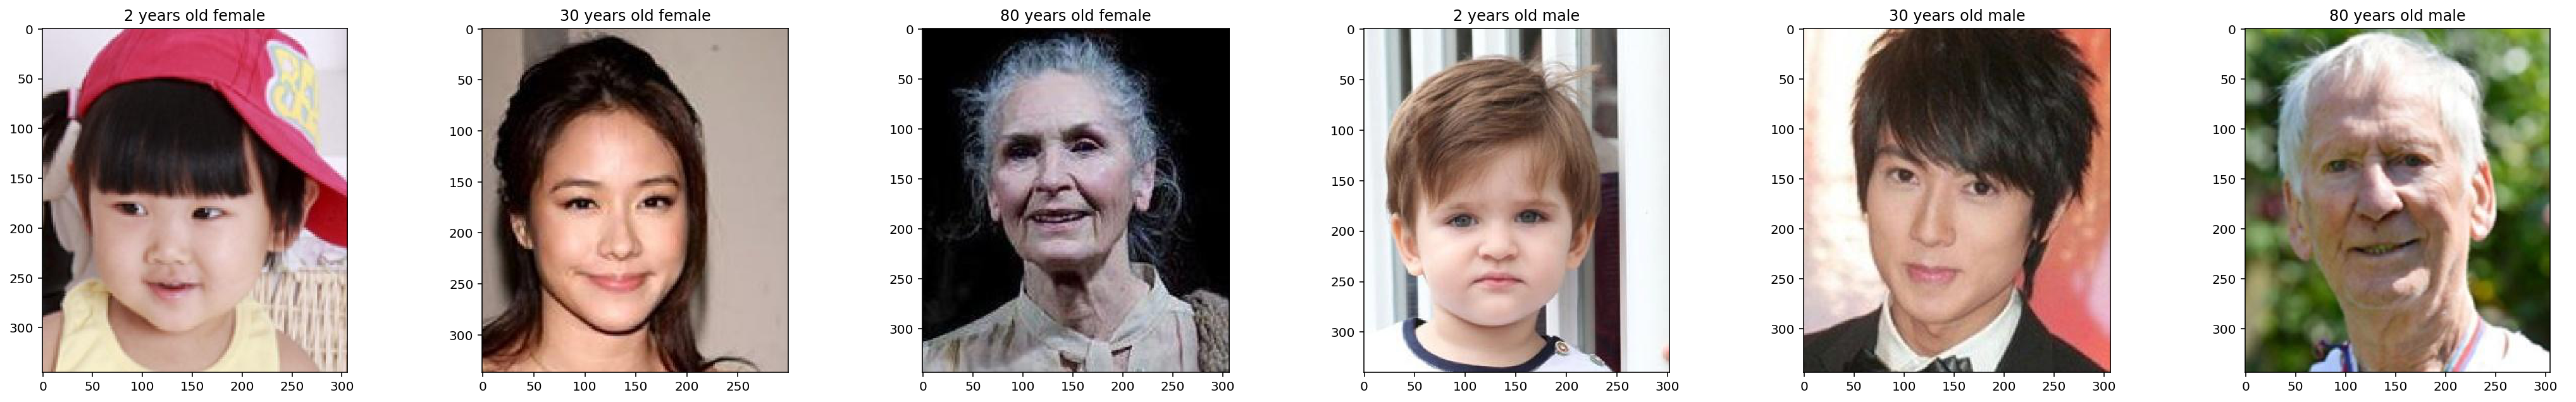

In [201]:
# preparing the variables
# choose the 6 examples and load images for drawing
dir_image = '/Users/yu/Documents/Duke/courses/20spring/IDS705 ML/HW/assignment3/All-Age-Faces Dataset/original images/'

img = [mpl.image.imread(dir_image + '00000A02.jpg'), mpl.image.imread(dir_image + '03492A30.jpg'), mpl.image.imread(dir_image + '07360A80.jpg'),
            mpl.image.imread(dir_image + '07390A02.jpg'), mpl.image.imread(dir_image + '09533A30.jpg'), mpl.image.imread(dir_image + '13306A80.jpg')]
idx = [0, 3492, 7360, 7390, 9533, 13306]
age = [2, 30, 80, 2, 30 ,80]
gender = [0, 0, 0, 1, 1, 1]

#create a new figure for keypoints
fig = plt.figure(figsize = [36,5])
plt.title("6 examples of the data: 49 keypoints on the face and the original images", fontsize = 30)
plt.axis('off')

# adjust the distance between figures
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# plot for the 6 examples
for i in range(6):
    # seperate the figure into 1x5 smaller space to plot and plot in the jth subplot
    fig.add_subplot(1, 6, i+1)
    plt.xlim([0, 310])
    plt.ylim([340, 0])
    plt.scatter(keypoints[i, :, 0], keypoints[i, :, 1], c= 'green', s=20)
    plt.xlabel('pixels on x axis')
    plt.ylabel('pixels on y axis')

    #
#create a new figure for images
fig = plt.figure(figsize = [36,5])
plt.axis('off')

# adjust the distance between figures
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# plot for the 6 examples
for i in range(6):
    # seperate the figure into 1x5 smaller space to plot and plot in the jth subplot
    fig.add_subplot(1, 6, i+1)
    plt.imshow(img[i])
    if gender[i] == 0:
        plt.title(f'{age[i]} years old female')
    if gender[i] == 1:
        plt.title(f'{age[i]} years old male')
    

print("This dataset contains 49 keypoints on the face for each image, with labels of gender and age.")
print("A model of predicting gender or age by these keypoints can be trained by this dataset.")

**(c)** Formulate your supervised learning question: (a) What is your target variable (what are you trying to predict) and what predictors do you have available? Does your dataset require any preprocessing: is it clean (no missing values or erroneous data) and normalized (are each of the predictors of the same magnitude)?   
-> My target variable is "gender" (female = 0, male = 1).
The predictor variables I have are the 49 keypoints of each image.  
This dataset does not require any preprocessing because the number of keypoints I have for each image are all the same.

**(d)** What supervised learning technique will you use and why?   
-> KNN because the relationship between the response variable and predictor variables might not be linear and the predictor variables probably are correlated with each other. Moreover, there are too many predictor variables in the model. Therefore, KNN might be the best method to train the model.

**(e)** How will you evaluate performance and know whether you succeeded (e.g. ROC curves for binary classification, mean square error or $R^2$ for regression)?  
-> Since the response variable is a binary classification, I would use ROC curves to evaluate performance.

**(f)** Divide your dataset into training and testing datasets OR implement cross validation. Explain your approach and why you adopted it.

In [202]:
# separate the data into training and validation set
#keypoints_flat
#label_gender

# generate the array to separate the dataset
idx_train = np.arange(0, len(label_gender), 2)
idx_test = np.arange(1, len(label_gender), 2)

keypoints_flat_train = keypoints_flat[idx_train, :]
keypoints_flat_test = keypoints_flat[idx_test, :]
label_gender_train = label_gender[idx_train, :]
label_gender_test = label_gender[idx_test, :]

I separate the data into training and testing datasets because I want the training dataset and testing dataset have same proportion of both gender and age of images. Since the response variable for this analysis is gender, I cannot use StratifiedKFold to separate the dataset to make the proportion of both gender and age equally separated while doing k-fold cross validataion Therefore, I choose to separate it manually. 

**(g)** Run your analysis and show your performance. Include plots of your data and of performance

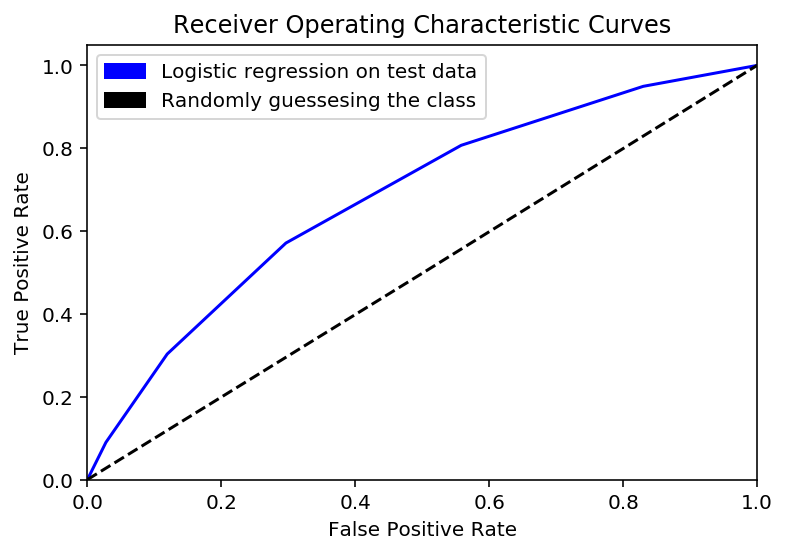

The AUC of the model is 0.6815257972505676


In [203]:
# train the model on training data and predict it on test data and draw the ROC curve
reg_Q4 = KNeighborsClassifier(n_neighbors= 5)
reg_Q4.fit(keypoints_flat_train, label_gender_train)
y_Q4_proba = reg_Q4.predict_proba(keypoints_flat_test)

# plot the ROC curve for test data
fpr, tpr, _ = roc_curve(label_gender_test, y_Q4_proba[:,1])
plt.plot(fpr, tpr, color = 'blue')

np.random.seed(100)
y_ran_prob = np.random.choice([0,1], size=len(lbl_b), replace=True, p=[0.5, 0.5])
fpr, tpr, _ = roc_curve(lbl_b, y_ran_prob)
plt.plot(fpr, tpr, color='black', linestyle='--')

blue_patch = patches.Patch(color='blue', label='Logistic regression on test data')
black_patch = patches.Patch(color='black', label='Randomly guessesing the class')
plt.legend(handles=[blue_patch, black_patch])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.show()

print(f"The AUC of the model is {roc_auc_score(label_gender_test, y_Q4_proba[:, 1])}")

**(h)** Describe how your system performed, where your supervised learning algorithm performed well, where it did not, and how you could improve it. Summarize the conclusions from your work (this should involve a degree of interpretation more so than "my classifier achieved an AUC of 0.8").  
-> My model performed bad since the AUC is only 0.68 and the ROC curve is near random guessing. This may because of the feature I used or my model choice is not proper for this kind of prediction. I can improve it by simply trying to use other supervised learning algorithm. I can even try to extract the features from the original images using different methods to fit the model, instead of using the keypoints provided by the data source provider.